# Tutorial Cover-Song-Identification based on Triplet-Loss

This notebook was created for the tutorial held at ISMIR-2024 "Deep-Learning 101 for Audio-based Music Information Retrieval".
If you use this notebook, please cite
```
@book{deeplearning-101-audiomir:book,
	author = {Peeters, Geoffroy and Meseguer-Brocal, Gabriel and Riou, Alain and Lattner, Stefan},
	title = {Deep Learning 101 for Audio-based MIR, ISMIR 2024 Tutorial},
	url = {https://geoffroypeeters.github.io/deeplearning-101-audiomir_book},
	address = {San Francisco, USA},
	year = {2024},
	month = November,
	doi = {???},
}
```

It illustrates the use of various deep-learning bricks to solve the task of "Cover-Song-Identification".

Part of the code is based on https://github.com/furkanyesiler/mov for the MOVE model and on https://gist.github.com/bwhite/3726239 for evaluation.
Datasets are available at https://www.covers1000.net/dataset.html for Cover-1000 and at https://github.com/MTG/da-tacos for DA-TACOS .

## Deployment

In case the notebook is run on GoogleColab or others, we first need to
- get the packages: `git clone``
- get the datasets

We also test the models on two different datasets:
- cover-1000
- Da-tacos

In [61]:
do_deploy = False

if do_deploy:
    !git clone https://github.com/geoffroypeeters/deeplearning-101-audiomir_notebook.git
    %cd deeplearning-101-audiomir_notebook
    !ls

    import urllib.request
    import shutil    
    ROOT = 'https://perso.telecom-paristech.fr/gpeeters/tuto_DL101forMIR/'

    hdf5_feat_file, pyjama_annot_file = 'cover1000_feat.hdf5.zip', 'cover1000.pyjama'
    #hdf5_feat_file, pyjama_annot_file = 'datacos-benchmark_feat.hdf5.zip', 'datacos-benchmark.pyjama'
    
    urllib.request.urlretrieve(ROOT + hdf5_feat_file, hdf5_feat_file)
    if hdf5_feat_file.endswith('.zip'): shutil.unpack_archive(hdf5_feat_file, './')
    urllib.request.urlretrieve(ROOT + pyjama_annot_file, pyjama_annot_file)

    ROOT = './'

else: 

    ROOT = '/tsi/data_doctorants/gpeeters/_data/'

config_file = 'config_cover.yaml'

do_wandb = False
import pprint as pp
import yaml
from munch import munchify
with open(config_file, 'r') as fid: 
    cfg_dic = yaml.safe_load(fid)
config = munchify(cfg_dic)
pp.pprint(config)

{'dataset': Munch({'base': 'datacos-benchmark'}),
 'model': {'block_l': [{'sequential_l': [{'layer_l': [['Conv2d',
                                                       {'in_channels': -1,
                                                        'kernel_size': [12,
                                                                        180],
                                                        'out_channels': 256,
                                                        'stride': [1, 1]}],
                                                      ['Activation', 'PReLU'],
                                                      ['MaxPool2d',
                                                       {'kernel_size': [12, 1],
                                                        'stride': [1, 1]}]]},
                                         {'layer_l': [['Conv2d',
                                                       {'in_channels': -1,
                                                        'k

## Import packages

In [62]:
import torch
from torch import nn
import torch.nn.functional as F
#import torchaudio
from torch.utils.data import Dataset
import torch.optim as optim
import torchsummary

! pip install lightning --quiet
import lightning.pytorch as pl
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

! pip install wandb --quiet
import wandb
from pytorch_lightning.loggers import WandbLogger

import json
import yaml
import h5py
import pprint as pp
from tqdm import tqdm
import datetime


import librosa
import matplotlib.pyplot as plt
import numpy as np

from argparse import Namespace

# -----------------------------
import model_factory 
import importlib
importlib.reload(model_factory) 

from argparse import Namespace
! pip install munch --quiet
from munch import munchify

## Set fixed seed for reproducibility

In [63]:
import random
seed = 42
torch.manual_seed(seed)         # For CPU
random.seed(seed)               # For Python's built-in random module
np.random.seed(seed)            # For NumPy
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)          # For current GPU
    torch.cuda.manual_seed_all(seed) 

## Parameters

In [64]:
hdf5_feat_file = f'{ROOT}/{config.dataset.base}_feat.hdf5'
pyjama_annot_file = f'{ROOT}/{config.dataset.base}.pyjama'

param_model = Namespace()
param_model.num_of_labels = 16
param_model.emb_size = 32   #16000
param_model.sum_method = 4
param_model.final_activation = 3
param_model.downsampling_parameters = 2

param_model.margin =  1.0
param_model.mining_strategy = 1
param_model.norm_dist = 1
param_model.lr = 0.1
param_model.momentum = 0
param_model.nb_epoch = 100

param_model.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

param_lightning = Namespace()
param_lightning.max_epochs = 500
param_lightning.dirpath='./_cover_lighning/'
param_lightning.filename='best_model_cover'

param_wandb = Namespace()
param_wandb.save_dir = './_cover_wandb/'
param_wandb.project_name = 'wandb_cover'


## Dataloader

### Test loading pyjama/hdf5

All the audio data of a dataset are stored in a single [.hdf5](https://docs.h5py.org/) file.
Each `key` corresponds to an entry, a specific audiofile.
Its array contains the audio features (here the CREMA features matrix).

All the annotations of a dataset are stored in a single *.pyjama file.
As [JAMS](https://github.com/marl/jams) files, .pyjama files are JSON files.
However, a single .pyjama file can contain the annotations of ALL entries of a dataset.
Its specifications are described here [DOC](https://github.com/geoffroypeeters/pyjama).
The values of the `filepath` field of the .pyjama file correspond to the `key` values of the .hdf5 file.


In [65]:
with open(pyjama_annot_file, encoding = "utf-8") as json_fid:
    data_d = json.load(json_fid)
entry_l = data_d['collection']['entry']

# --- example of entry (for illustration)
pp.pprint(entry_l[0:2])

# --- get list of audio files
audiofile_l = [entry['filepath'][0]['value'] for entry in entry_l]
print(f'number of audio: {len(audiofile_l)}')
# --- example of audio (for illustration)
pp.pprint(audiofile_l[:5])

with h5py.File(hdf5_feat_file, 'r') as hdf5_fid:
    #audiofile_l = [key for key in hdf5_fid['/'].keys()]
    pp.pprint(f"feature shape: {hdf5_fid[audiofile_l[0]][:].shape}")

[{'filepath': [{'value': 'P_1002'}],
  'performance-id': [{'value': 'P_1002'}],
  'work-id': [{'value': 'W_1002'}]},
 {'filepath': [{'value': 'P_122525'}],
  'performance-id': [{'value': 'P_122525'}],
  'work-id': [{'value': 'W_1002'}]}]
number of audio: 15000
['P_1002', 'P_122525', 'P_129091', 'P_145072', 'P_2497']
'feature shape: (19492, 12)'


We check how many entry are contained in the dataset, how many unique `performance-id` and how many unique `work-id`.

In [66]:
with open(pyjama_annot_file, encoding = "utf-8") as json_fid: 
    data_d = json.load(json_fid)
entry_l = data_d['collection']['entry']
performanceid_l  = set([entry['performance-id'][0]['value'] for entry in entry_l])
workid_l  = set([entry['work-id'][0]['value'] for entry in entry_l])

print(f'number of tracks {len(entry_l)}')
print(f'number of performance {len(performanceid_l)}')
print(f'number of work {len(workid_l)}')


number of tracks 15000
number of performance 15000
number of work 3000


### Create Dataset

The class `CoverDataset` (a subset of pytorch `Dataset` class) is responsible for providing (with the `__getitem` method) four performances (performance-id) that belongs to the same work-id.

- `getitem_by_performanceid`: will truncate/pad the feature to achieve a length of 1800
- `__getitem__`: for a given work-id, it will randomy select a subset of 4 performances that belong to it
- '__init__': 
  - will read the hdf5_feat_file and pyjama_annot_file
  - split their content according to training and test (selection ensure that work-id are different in train and valid)
  - create a set of mapping dictionary 
  - create a list of cliques: a clique groups performance corresponding to the same workid. Here, if one workid has many performanceid we duplicate the correspond clique so that it appears more often in the `__getitem__` method
  - store all the necessary data in memory (of CPU) to fasten later access: `self.data_d[key=performanceid]`. Part of the data are the feature. We map the 12-dimension CREMA features to 23-dimension by concatenating them with their transpose version. This is specific to the MOVE model which first layer try to obtain a pitch-shift invariance with the `[Conv2d, {'in_channels':-1, 'out_channels':256, 'kernel_size':[12, 180], 'stride':[1,1]}]` and `[MaxPool2d, {'kernel_size':[12, 1], 'stride': [1, 1]}]` layers.
  

In [67]:
class CoverDataset(Dataset):
    """
    description
    """

    def __init__(self, hdf5_feat_file, pyjama_annot_file, do_train):
        
        self.h = 23
        self.w = 1800
        
        with open(pyjama_annot_file, encoding = "utf-8") as json_fid: data_d = json.load(json_fid)
        entry_l = data_d['collection']['entry']
        
        all_workid_l  = list(set([entry['work-id'][0]['value'] for entry in entry_l]))
        performanceid_l  = set([entry['performance-id'][0]['value'] for entry in entry_l])

        self.do_train = do_train
        if self.do_train:   workid_l = [all_workid_l[idx] for idx in range(len(all_workid_l)) if (idx % 5) != 0]
        else:               workid_l = [all_workid_l[idx] for idx in range(len(all_workid_l)) if (idx % 5) == 0]

        self.workid_to_perfomanceid_d = {}
        for workid in workid_l:
            self.workid_to_perfomanceid_d[workid] = [entry['performance-id'][0]['value'] for entry in entry_l if entry['work-id'][0]['value']==workid]
        
        # --- each element of the self.clique_list_l correspond to a single work-id 
        # --- but if a work-id has many performance-id we create several self.clique_list_l for it
        # --- such that it appears more often during the __getitem__
        self.clique_list_l = []
        for workid in self.workid_to_perfomanceid_d.keys():
            # --- for each workid, we check the number of performanceid
            # --- if this number is large this workid will be present in many clique
            nb_performanceid = len(self.workid_to_perfomanceid_d[workid])
            #print(len(self.clique_list_l), workid, nb_performanceid)
            if nb_performanceid < 2:     pass
            elif nb_performanceid < 6:   self.clique_list_l.extend([workid] * 1)
            elif nb_performanceid < 10:  self.clique_list_l.extend([workid] * 2)
            elif nb_performanceid < 14:  self.clique_list_l.extend([workid] * 3)
            else:                        self.clique_list_l.extend([workid] * 4)

        self.data_d = {}
        with h5py.File(hdf5_feat_file, 'r') as feat_fid:
            for workid in self.workid_to_perfomanceid_d.keys():
                # --- get the list of performanceid associated to this workid
                perfomanceid_l = self.workid_to_perfomanceid_d[workid]
                for performanceid in perfomanceid_l:
                    self.data_d[performanceid] = {}
                    self.data_d[performanceid]['workid'] = workid
                    self.data_d[performanceid]['perfomanceid'] = performanceid
                    # --- Get data and convert to make rotation invariant -> self.data_d (1, 23, 1800)
                    data = torch.from_numpy(feat_fid['/' +  str(performanceid) + '/'][:].T).unsqueeze(0)
                    self.data_d[performanceid]['X'] = torch.concatenate((data, data), dim=1)[:,:-1,:]


    def __len__(self):
        return len(self.clique_list_l)


    def getitem_by_performanceid(self, perfomanceid):
        X = self.data_d[perfomanceid]['X']
        # if the song is longer than the required width, choose a random start point to crop
        if X.shape[2] >= self.w: 
            X = X[:, :, 0:self.w]
        else:                       
            X = torch.cat((X, torch.zeros([1, self.h, self.w - X.shape[2]])), 2)
        return X, self.data_d[perfomanceid]['workid']


    def __getitem__(self, idx_clique):
        
        workid = self.clique_list_l[idx_clique]  # getting the clique chosen by the dataloader
        
        # selecting 4 songs from the given clique
        if len(self.workid_to_perfomanceid_d[workid]) == 2:  # if the clique size is 2, repeat the already selected songs
            performanceid_1, performanceid_2 = np.random.choice(self.workid_to_perfomanceid_d[workid], 2, replace=False)
            performanceid_3, performanceid_4 = performanceid_1, performanceid_2
        elif len(self.workid_to_perfomanceid_d[workid]) == 3:  # if the clique size is 3, choose one of the songs twice
            performanceid_1, performanceid_2, performanceid_3 = np.random.choice(self.workid_to_perfomanceid_d[workid], 3, replace=False)
            performanceid_4 = np.random.choice(self.workid_to_perfomanceid_d[workid], 1, replace=False)[0]
        else:  # if the clique size is larger than or equal to 4, choose 4 songs randomly
            performanceid_1, performanceid_2, performanceid_3, performanceid_4 = np.random.choice(self.workid_to_perfomanceid_d[workid], 4, replace=False)
        
        X_l = []
        for perfomanceid in [performanceid_1, performanceid_2, performanceid_3, performanceid_4]:
            X, _ = self.getitem_by_performanceid(perfomanceid)
            X_l.append(X)
        
        return torch.stack(X_l, 0), workid

train_dataset = CoverDataset(hdf5_feat_file, pyjama_annot_file, do_train=True)
valid_dataset = CoverDataset(hdf5_feat_file, pyjama_annot_file, do_train=False)


torch.Size([4, 1, 23, 1800])
W_401


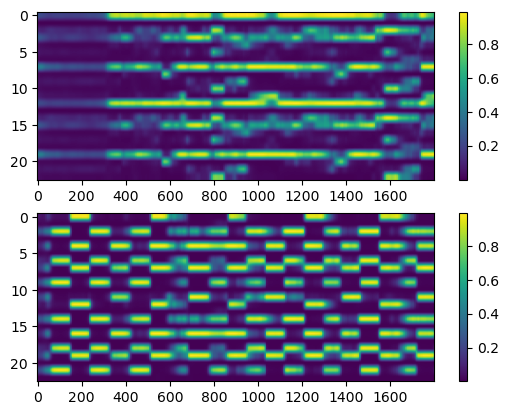

In [68]:
# --- TEST
items, label = train_dataset[0]
print(items.size())
print(label)

plt.subplot(211); plt.imshow(items[0,0,:,:].cpu().numpy(), aspect='auto'); plt.colorbar();
plt.subplot(212); plt.imshow(items[1,0,:,:].cpu().numpy(), aspect='auto'); plt.colorbar();


### Create DataLoader

We create the dataloader for the training and validation data from the corresponding dataset.
We use here a specific `collate function`, i.e. the function used to collate the data provided by the `__getitem__` of the dataset.

In [69]:
def triplet_mining_collate(batch):
    """
    Custom collate function for triplet mining
    :param batch: elements of the mini-batch (pcp features and labels)
    :return: collated elements
    """
    items = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    return torch.cat(items, 0), labels

In [70]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=param_model.num_of_labels, shuffle=True, collate_fn=triplet_mining_collate, num_workers=9, drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=param_model.num_of_labels, shuffle=False, collate_fn=triplet_mining_collate, num_workers=9, drop_last=True)

In [71]:
# --- TEST
items, labels = next(iter(train_dataloader))
print(items.size())
print(labels)

torch.Size([64, 1, 23, 1800])
['W_27790', 'W_111535', 'W_52963', 'W_3995', 'W_112910', 'W_12992', 'W_3162', 'W_22053', 'W_1795', 'W_9276', 'W_18505', 'W_113981', 'W_4767', 'W_14485', 'W_9560', 'W_5461']


## Model

The pytorch model is generated automatically based on the content of the `config_cover.yaml` file.

In [72]:
importlib.reload(model_factory) 

m, C, H, T = 32, 1, 23, 1800
model = model = model_factory.NetModel(config, [m, C, H, T])
model = model.to(param_model.device)

### Check the model 

We can check the model either using
- print(model)
- the `verbose` mode of the `forward` of the model
- the `torchsummary.summary` method

The model used has `1,869,093` parameters to be trained.

In [73]:
# --- TEST
#print(model)

X = torch.randn(m, C, H, T).to(param_model.device)
print(model(X, True).size())

#torchsummary.summary(model, (C, H, T))

0/0---------------------------------
Sequential(
  (0): Conv2d(1, 256, kernel_size=(12, 180), stride=(1, 1), padding=valid)
  (1): PReLU(num_parameters=1)
  (2): MaxPool2d(kernel_size=[12, 1], stride=[1, 1], padding=0, dilation=1, ceil_mode=False)
)
> in: torch.Size([32, 1, 23, 1800])
> out: torch.Size([32, 256, 1, 1621])
0/1---------------------------------
Sequential(
  (0): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), padding=valid)
  (1): PReLU(num_parameters=1)
)
> in: torch.Size([32, 256, 1, 1621])
> out: torch.Size([32, 256, 1, 1617])
0/2---------------------------------
Sequential(
  (0): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), padding=valid)
  (1): PReLU(num_parameters=1)
)
> in: torch.Size([32, 256, 1, 1617])
> out: torch.Size([32, 256, 1, 1613])
0/3---------------------------------
Sequential(
  (0): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), padding=valid)
  (1): PReLU(num_parameters=1)
)
> in: torch.Size([32, 256, 1, 1613])
> out: torch.Size([32

### Define losses

The triplet loss using online triple-mining we use necessitates the writing of specific functions.
- `pairwise_distance_matrix`: compute the squared eucliden distance between the embeddings of all data in a batch 
- `f_renumber`: replicates the single work-id associated to an output of `__getitem__` to the 4 features (hence 4 embeddings) provided by it  
- `triplet_loss_mining` : is the main function which 
  - compute the distances 
  - compute the positive (performances with same workid) and negative mask (performances with different workid) 
  - select the correct triplet using various methods (random, semi-hard, hard) 
  - compute the triplet loss
- `triplet_mining_random`, `triplet_mining_semihard`, `triplet_mining_hard` are the corresponding functions

In [74]:
def pairwise_distance_matrix(x, y=None, eps=1e-12):
    """
    Calculating squared euclidean distances between the elements of two tensors
    :param x: first tensor
    :param y: second tensor (optional)
    :param eps: epsilon value for avoiding div by zero
    :return: pairwise distance matrix
    """
    x_norm = x.pow(2).sum(dim=1).view(-1, 1)
    if y is not None:
        y_norm = y.pow(2).sum(dim=1).view(1, -1)
    else:
        y = x
        y_norm = x_norm.view(1, -1)

    dist = x_norm + y_norm - 2 * torch.mm(x, y.t().contiguous())
    return torch.clamp(dist, eps, np.inf)

In [75]:
def f_renumber(labels):
    """
    renumber the labels (which correspond to work-id) starting from 0 and get 4 of them each time
    """
    aux = {}
    i_labels = []
    for l in labels:
        if l not in aux:
            aux[l] = len(aux)
        i_labels += [aux[l]]*4
    return i_labels

#f_renumber([300, 200, 500, 300])

In [76]:
def triplet_loss_mining(embedding_m, labels, param_model):
    """
    Online mining function for selecting the triplets
    """

    batch_size = embedding_m.size(0)

    # creating positive and negative masks for online mining
    i_labels = f_renumber(labels)
    i_labels = torch.Tensor(i_labels).view(-1, 1).to(param_model.device)
    # --- get a ones matrix with zero on main diagonal (to avoid selecting the anchor itself for positive or negative)
    mask_diag = (1 - torch.eye(batch_size)).long().to(param_model.device)
    # --- the mask with 1 if same work-id 0 otherwise
    sameworkid_mask = (pairwise_distance_matrix(i_labels) < 0.5).long()
    # --- same work-id but not the anchor
    mask_pos = mask_diag * sameworkid_mask
    # --- different work-id and not the anchor
    mask_neg = mask_diag * (1 - mask_pos)

    # getting the pairwise distance matrix
    dist_all = pairwise_distance_matrix(embedding_m)  
    # normalizing the distances by the embedding size
    if param_model.norm_dist == 1:  dist_all /= param_model.emb_size

    if param_model.mining_strategy == 0:    dist_pos, dist_neg = triplet_mining_random(dist_all, mask_pos, mask_neg)
    elif param_model.mining_strategy == 1:  dist_pos, dist_neg = triplet_mining_semihard(dist_all, mask_pos, mask_neg, param_model.margin)
    else:                                   dist_pos, dist_neg = triplet_mining_hard(dist_all, mask_pos, mask_neg, param_model.device)
    
    loss = F.relu(dist_pos + (param_model.margin - dist_neg))  # calculating triplet loss
    
    nb1 = torch.sum(dist_pos+param_model.margin < dist_neg).item()
    
    return loss.mean(), nb1


def triplet_mining_random(dist_all, mask_pos, mask_neg):
    """
    Performs online random triplet mining
    """
    # selecting the positive elements of triplets
    # we consider each row as an anchor and takes the maximum of the masked row (mask_pos) as the positive
    _, sel_pos = torch.max(mask_pos.float() + torch.rand_like(dist_all), dim=1)
    dists_pos = torch.gather(input=dist_all, dim=1, index=sel_pos.view(-1, 1))
    
    # selecting the negative elements of triplets
    # we consider each row as an anchor and takes the maximum of the masked row (mask_neg) as the negative
    _, sel_neg = torch.max(mask_neg.float() + torch.rand_like(dist_all), dim=1)
    dists_neg = torch.gather(input=dist_all, dim=1, index=sel_neg.view(-1, 1))

    return dists_pos, dists_neg


def triplet_mining_semihard(dist_all, mask_pos, mask_neg, margin):
    """
    Performs online semi-hard triplet mining (a random positive, a semi-hard negative)
    """

    # --- the code below seems wrong
    # --- need criteria
    # 1) should be negative (should be from a different work-id)
    # 2) should be P < N < P+margin

    # selecting the positive elements of triplets
    # we consider each row as an anchor and takes the maximum of the masked row (mask_pos) as the positive
    _, sel_pos = torch.max(mask_pos.float() + torch.rand_like(dist_all), dim=1)
    dists_pos = torch.gather(input=dist_all, dim=1, index=sel_pos.view(-1, 1))
    
    # selecting the negative elements of triplets
    _, sel_neg = torch.max( 
                            (mask_neg + mask_neg * (dist_all < (dists_pos.expand_as(dist_all)).long()+margin)).float() 
                           + torch.rand_like(dist_all), 
                           dim=1)

    dists_neg = torch.gather(input=dist_all, dim=1, index=sel_neg.view(-1, 1))

    return dists_pos, dists_neg


def triplet_mining_hard(dist_all, mask_pos, mask_neg, device):
    """
    Performs online hard triplet mining (both positive and negative)
    """

    # --- the code below seems wrong
    # --- need criteria
    # 1) should be negative (from a different work-id)
    # 2) should be N < P

    # selecting the positive elements of triplets
    # --- for each anchor (row) we take the positive with the largest distance
    _, sel_pos = torch.max(dist_all * mask_pos.float(), 1)
    dists_pos = torch.gather(input=dist_all, dim=1, index=sel_pos.view(-1, 1))

    # modifying the negative mask for hard mining (because we will use the min)
    # --- if mask_neg==0 then inf   
    # --- if mask_neg==1 then 1
    true_value = torch.tensor(float('inf'), device=device)
    false_value = torch.tensor(1., device=device)
    mask_neg = torch.where(mask_neg == 0, true_value, false_value)
    # selecting the negative elements of triplets
    # --- for each anchor (row) we take the negative with the smallest distance
    _, sel_neg = torch.min(dist_all + mask_neg.float(), dim=1)
    dists_neg = torch.gather(input=dist_all, dim=1, index=sel_neg.view(-1, 1))

    return dists_pos, dists_neg

## Training using TorchLightning

### W&B configuration

We configure `https://wandb.ai/` to monitor the training of our model.
As `tensorboard`, `wandb` is a server that keep track of the performance in real-time of a raining. 
Unlike `tensorboard`, `wandb` server runs online and can therefore be accessed from anywhere (you can monitor your training in the bus, train, metro).

In [77]:
if do_wandb:
    train_config_d = {}
    current_datetime = datetime.datetime.now()
    formatted_datetime = current_datetime.strftime("%Y-%m-%d-%H-%M-%S")
    expe_name = formatted_datetime
    wandb.finish()
    wandb_logger = WandbLogger(project = param_wandb.project_name, name = expe_name, save_dir = param_wandb.save_dir )
    wandb_logger.experiment.config.update(train_config_d)

### TorchLightning

In [78]:
class CoverLigthing(pl.LightningModule):
    def __init__(self, in_model):
        super().__init__()
        self.model = in_model
        self.loss = nn.BCEWithLogitsLoss()

    def training_step(self, batch, batch_idx):
        items, labels = batch
        embedding_m = self.model(items.to(param_model.device))
        loss, oktriplet = triplet_loss_mining(embedding_m, labels, param_model)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_oktriplet", oktriplet, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        items, labels = batch
        embedding_m = self.model(items.to(param_model.device))
        loss, oktriplet = triplet_loss_mining(embedding_m, labels, param_model)
        self.log("valid_loss", loss, prog_bar=True)
        self.log("valid_oktriplet", oktriplet, prog_bar=True)
         
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=param_model.lr, momentum=param_model.momentum)
        return optimizer

### Training

We train the model and apply a early-stopping based on the validation loss.
We also monitor the number of triplets that are OK (i.e. $d(A,P)+\alpha < d(A,N)$) for the training and validation dataset.

In [79]:
my_lighting = CoverLigthing(model)
early_stop_callback = EarlyStopping(monitor="valid_loss", patience=50, verbose=True, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='valid_loss', dirpath=param_lightning.dirpath, filename=param_lightning.filename, save_top_k=1, mode='min')
if do_wandb:
    trainer = pl.Trainer(accelerator="gpu",  logger = wandb_logger, max_epochs = param_lightning.max_epochs, callbacks = [early_stop_callback, checkpoint_callback])
else:
    trainer = pl.Trainer(accelerator="gpu",  max_epochs = param_lightning.max_epochs, callbacks = [early_stop_callback, checkpoint_callback])
trainer.fit(model=my_lighting, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | NetModel          | 1.9 M 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.476     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 147/147 [00:34<00:00,  4.30it/s, v_num=68, train_loss=1.390, train_oktriplet=0.000, valid_loss=1.350, valid_oktriplet=0.325]

Metric valid_loss improved. New best score: 1.352


Epoch 2: 100%|██████████| 147/147 [00:41<00:00,  3.56it/s, v_num=68, train_loss=1.160, train_oktriplet=0.000, valid_loss=1.340, valid_oktriplet=1.120]

Metric valid_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.341


Epoch 3: 100%|██████████| 147/147 [00:41<00:00,  3.53it/s, v_num=68, train_loss=1.210, train_oktriplet=0.000, valid_loss=1.270, valid_oktriplet=0.675]

Metric valid_loss improved by 0.071 >= min_delta = 0.0. New best score: 1.270


Epoch 4: 100%|██████████| 147/147 [00:41<00:00,  3.55it/s, v_num=68, train_loss=1.160, train_oktriplet=0.000, valid_loss=1.130, valid_oktriplet=1.100]

Metric valid_loss improved by 0.137 >= min_delta = 0.0. New best score: 1.133


Epoch 5: 100%|██████████| 147/147 [00:41<00:00,  3.52it/s, v_num=68, train_loss=1.140, train_oktriplet=0.000, valid_loss=1.090, valid_oktriplet=1.000]

Metric valid_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.088


Epoch 12: 100%|██████████| 147/147 [00:42<00:00,  3.47it/s, v_num=68, train_loss=1.100, train_oktriplet=0.000, valid_loss=1.040, valid_oktriplet=0.675]

Metric valid_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.036


Epoch 16: 100%|██████████| 147/147 [00:42<00:00,  3.47it/s, v_num=68, train_loss=1.170, train_oktriplet=0.000, valid_loss=1.010, valid_oktriplet=0.550]

Metric valid_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.014


Epoch 29: 100%|██████████| 147/147 [01:06<00:00,  2.20it/s, v_num=68, train_loss=1.180, train_oktriplet=1.000, valid_loss=0.989, valid_oktriplet=1.520]

Metric valid_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.989


Epoch 40: 100%|██████████| 147/147 [01:06<00:00,  2.22it/s, v_num=68, train_loss=1.130, train_oktriplet=2.000, valid_loss=0.988, valid_oktriplet=2.620]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.988


Epoch 51: 100%|██████████| 147/147 [01:04<00:00,  2.28it/s, v_num=68, train_loss=0.972, train_oktriplet=0.000, valid_loss=0.982, valid_oktriplet=1.500]

Metric valid_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.982


Epoch 53: 100%|██████████| 147/147 [00:57<00:00,  2.56it/s, v_num=68, train_loss=1.060, train_oktriplet=0.000, valid_loss=0.978, valid_oktriplet=2.800]

Metric valid_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.978


Epoch 57: 100%|██████████| 147/147 [00:44<00:00,  3.31it/s, v_num=68, train_loss=0.996, train_oktriplet=5.000, valid_loss=0.970, valid_oktriplet=2.100]

Metric valid_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.970


Epoch 68: 100%|██████████| 147/147 [01:06<00:00,  2.20it/s, v_num=68, train_loss=0.882, train_oktriplet=5.000, valid_loss=0.936, valid_oktriplet=0.900]

Metric valid_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.936


Epoch 87: 100%|██████████| 147/147 [01:07<00:00,  2.17it/s, v_num=68, train_loss=1.010, train_oktriplet=0.000, valid_loss=0.932, valid_oktriplet=1.200]

Metric valid_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.932


Epoch 103: 100%|██████████| 147/147 [00:43<00:00,  3.37it/s, v_num=68, train_loss=1.160, train_oktriplet=3.000, valid_loss=0.909, valid_oktriplet=2.400]

Metric valid_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.909


Epoch 150: 100%|██████████| 147/147 [00:43<00:00,  3.38it/s, v_num=68, train_loss=0.919, train_oktriplet=3.000, valid_loss=0.908, valid_oktriplet=2.780]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.908


Epoch 171: 100%|██████████| 147/147 [01:02<00:00,  2.35it/s, v_num=68, train_loss=nan.0, train_oktriplet=0.000, valid_loss=nan.0, valid_oktriplet=0.000]

Monitored metric valid_loss = nan is not finite. Previous best value was 0.908. Signaling Trainer to stop.


Epoch 171: 100%|██████████| 147/147 [01:02<00:00,  2.35it/s, v_num=68, train_loss=nan.0, train_oktriplet=0.000, valid_loss=nan.0, valid_oktriplet=0.000]


## Evaluation

We first load the best model obtained during training.

In [84]:
best_model_path = checkpoint_callback.best_model_path
#best_model_path = 'my_model/best_model.ckpt'
print(f"Best model saved at: {best_model_path}")
my_lighting = CoverLigthing.load_from_checkpoint(best_model_path, in_model=model)

print( type(model) ) 
print( type(my_lighting) )
print( type(my_lighting.model) )

model = my_lighting.model

Best model saved at: /home/ids/gpeeters/proj_tuto-ISMIR2024/code/_cover_lighning/best_model_cover-v2.ckpt
<class 'model_factory.NetModel'>
<class '__main__.CoverLigthing'>
<class 'model_factory.NetModel'>


We send all the data of the validation dataset to the model, get their embedding and compute the distance matrix between all items.

In [85]:
model.to(param_model.device)
with torch.no_grad():
    model.eval()
    embed_all_m = torch.tensor([], device=param_model.device)
    coverid_l = []
    for performanceid in valid_dataset.data_d.keys():
        items, coverid = valid_dataset.getitem_by_performanceid(performanceid)
        embedding_m = model(items.unsqueeze(0).to(param_model.device))
        embed_all_m = torch.cat((embed_all_m, embedding_m), dim=0) 
        coverid_l.append(coverid)
        
dist_all_m = pairwise_distance_matrix(embed_all_m)
if param_model.norm_dist == 1:  dist_all_m /= param_model.emb_size


#### Compute Ranking Metrics

In [86]:
def F_mean_rank(relevance):
    return relevance.nonzero()[0][0]+1

def F_mean_reciprocal_rank(relevance):
    return 1./ F_mean_rank(relevance)

def F_precision_at_k(relevance, k):
    return np.mean(relevance[:k] != 0)

def F_average_precision(relevance):
    out = [F_precision_at_k(relevance, k + 1) for k in range(relevance.size) if relevance[k]]
    return np.mean(out)

For each item of the validation dataset (one row of the distance matrix), we compute the mean-rank, mean-reciprocal-rank, precision@1, @5 @10 and mean Average Precision (mAP).
We average over all items.

In [87]:
dist_all_np = dist_all_m.cpu().numpy()
nb_target = dist_all_np.shape[0]
dist_all_np += 1e6*np.eye(nb_target) # --- to prevent detecting the target itself
mean_rank_l, mean_reciprocal_rank_l, precision_at_1_l, precision_at_5_l, precision_at_10_l, average_precision_l = [], [], [], [], [], []

score_d = {}
for key in ['mean_rank', 'mean_reciprocal_rank', 'precision_at_1','precision_at_5', 'precision_at_10', 'average_precision']:
    score_d[key] = [] 

for idx_target in range(nb_target):
    relevance = np.asarray([1 if coverid_l[pos]==coverid_l[idx_target] else 0 for pos in np.argsort(dist_all_np[idx_target,:])])    
    score_d['mean_rank'].append( F_mean_rank(relevance) )
    score_d['mean_reciprocal_rank'].append( F_mean_reciprocal_rank(relevance) )
    score_d['precision_at_1'].append( F_precision_at_k(relevance, 1) )
    score_d['precision_at_5'].append( F_precision_at_k(relevance, 5) )
    score_d['precision_at_10'].append( F_precision_at_k(relevance, 10) )
    score_d['average_precision'].append( F_precision_at_k(relevance, 10) )
    
for key in score_d.keys():
    print(f"{key}: {np.mean(np.asarray(score_d[key]))}")

mean_rank: 465.3181818181818
mean_reciprocal_rank: 0.20163510419972283
precision_at_1: 0.1369949494949495
precision_at_5: 0.0931818181818182
precision_at_10: 0.07348484848484849
average_precision: 0.07348484848484849


In [ ]:
import shutil
shutil.copy(config.output_file.origin, config.output_file.origin + config.output_file.ext)